In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import difflib
import sys
import glob

from tqdm.auto import tqdm
from pprint import pprint

import plotnine
from plotnine import *

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import get_img_df,filter_exclude, stats_GAEZ_Yearbook

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [6]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

In [7]:
# set the scale to convert GYGA_pential to GYGA_attainable
GYGA_convert_scale = 0.8

### Get the GYGA data

In [9]:
# read GYGA (global yield gap atlas) data
GYGA = pd.read_csv('../Data/06_Yearbook/Agricultural_production/GYGA/GygaChina_Crop_potential_yield.csv')

# split station_name into city_name and province_name
GYGA['City'] = GYGA['STATIONNAME'].apply(lambda x:x.split('(')[0].strip())
GYGA['Province'] = GYGA['STATIONNAME'].apply(lambda x:x.split('(')[1][:-1].strip())

# split CROP into CROP and Irrigation
GYGA['crop'] = GYGA['CROP'].apply(lambda x:x.split(' ')[1].strip())
GYGA['water'] = GYGA['CROP'].apply(lambda x:x.split(' ')[0].strip())

# filter the rows that area in the research provinces
GYGA = GYGA[GYGA['Province'].isin(list(city_cn_en.values()))].sort_values('Province').reset_index(drop=True)

# remove unnucessay cols
GYGA = GYGA[['Province','City','crop','water','YW','YP']]

# rename crop to match GAEZ records
crop_rename_dict = {'rice':'Wetland_rice','wheat':'Wheat','maize':'Maize'}
GYGA = GYGA.replace(crop_rename_dict)

In [10]:
# divide GYGA into rainfed/irrigated
GYGA_rainfed = GYGA[GYGA['water']=='Rainfed'].rename(columns={'YW':'yield_potential'}).drop('YP', 1)
GYGA_irrigated = GYGA[GYGA['water']=='Irrigated'].rename(columns={'YP':'yield_potential'}).drop('YW', 1)

# concat GYGA data
GYGA_YP = pd.concat([GYGA_rainfed,GYGA_irrigated]).reset_index(drop=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11488\17851448.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11488\17851448.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


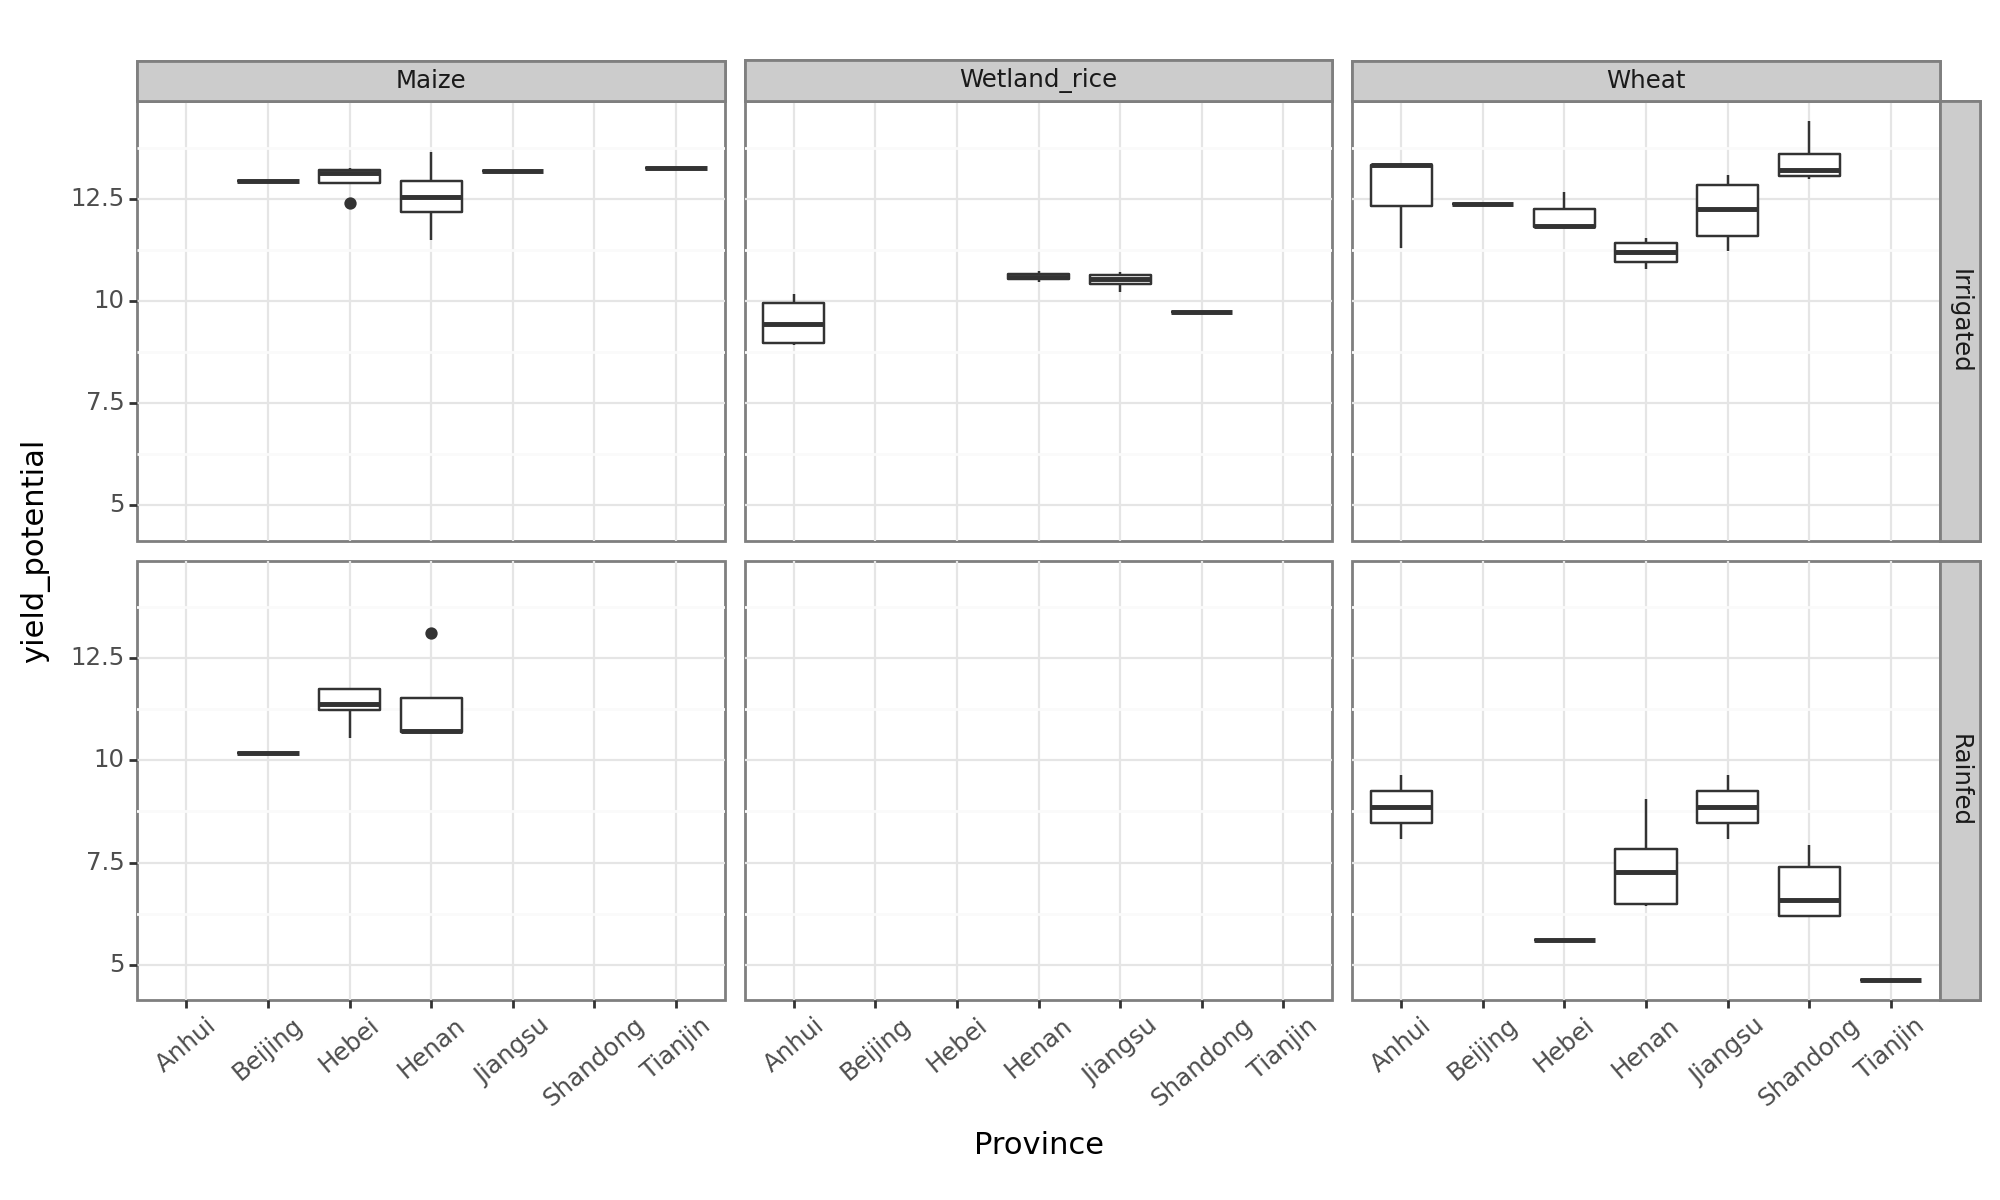

<Figure Size: (1000 x 600)>

In [11]:
# plot the GYGA attainable yield
plotnine.options.figure_size = (10, 6)
plotnine.options.dpi = 100

(ggplot(GYGA_YP,aes(x='Province',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw(base_size=11) +
 theme(axis_text_x=element_text(rotation=40))
)

### Fill the missing values using mean

In [12]:
# compute the mean values of existing records
GYGA_mean = GYGA_YP.groupby(['Province','crop','water']).mean().reset_index()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11488\877229026.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [13]:
# find missing combinations
All_combinations = itertools.product(GYGA_YP['Province'].unique(),GYGA_YP['crop'].unique(),GYGA_YP['water'].unique())
Exist_combinations = zip(GYGA_mean['Province'],GYGA_mean['crop'],GYGA_mean['water'])

lack_combinations = set(list(All_combinations)) - set(list(Exist_combinations))

In [14]:
# innitiate an empty df using lack_combinations
null_df = pd.DataFrame({i:[np.nan] for i in lack_combinations}).T.reset_index()
null_df.columns = GYGA_mean.columns

# function to compute mean YP give crop/water
def get_mean(crop,water):
  mean = GYGA_YP[(GYGA_YP['crop']==crop)&(GYGA_YP['water']==water)]['yield_potential'].mean()
  return mean

# concat null_df with GYGA
null_df['yield_potential'] = null_df.apply(lambda x: get_mean(x['crop'],x['water']),1)

# lastly, fill rainfed-rice with 0
null_df = null_df.fillna(0)

# append filling data
GYGA_fill = pd.concat([GYGA_YP,null_df])

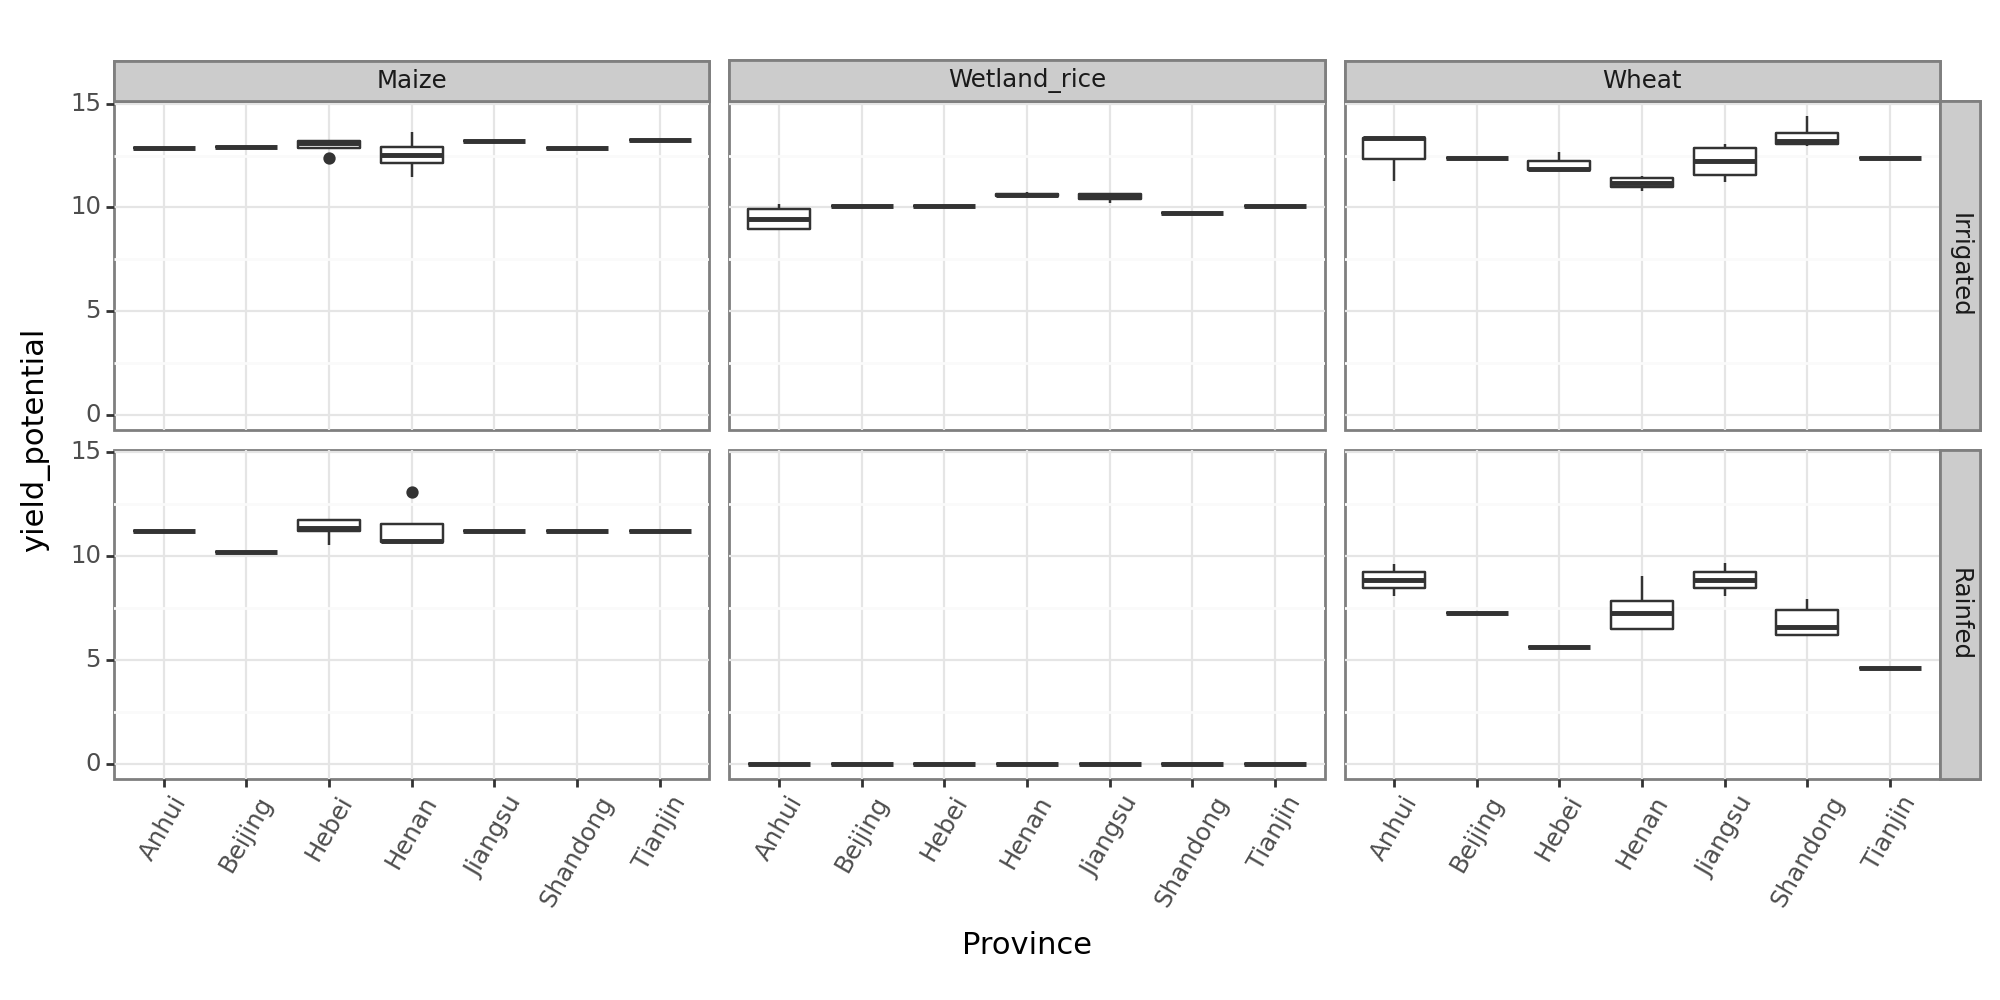

<Figure Size: (1000 x 500)>

In [15]:
# plot the filled GYGA data
plotnine.options.figure_size = (10, 5)
plotnine.options.dpi = 100

g = (ggplot(GYGA_fill,aes(x='Province',y='yield_potential')) +
 geom_boxplot() +
 facet_grid('water~crop') +
 theme_bw(base_size=11) +
 theme(axis_text_x=element_text(rotation=60))
)
g

In [17]:
g.save('../Figs/sup_13_GYGA_attainable_yield.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_13_GYGA_attainable_yield.svg


#### Compute the harvested area ratio for each province so we get the mean yield

In [18]:
# actual harvested area
actual_area = get_img_df(img_path = GAEZ_list,
              theme = 'GAEZ_5',
              variable = ['Harvested_area'],
              time = '2010',
              crop = ['Maize','Wetland_rice','Wheat'],
              water = ['Rainfed','Irrigated'])

In [19]:
actual_area['Province'] = None
actual_area['area_ratio'] = None

stats_dfs = []
for idx,row in tqdm(actual_area.iterrows(),total=len(actual_area)):
  crop = row['crop']
  water = row['water']
  img = ee.Image(row['GEE_path'])

  stats = img.reduceRegions(collection=NCP_provinces,scale=GAEZ_pix_scale,reducer='sum').getInfo()
  stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['sum']] for i in stats['features']}).T.reset_index()
  stats_df.columns = ['Province','area']

  stats_df['crop'] = crop
  stats_df['water'] = water

  stats_dfs.append(stats_df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
# get the harvested area (ha) for each province
area_water_each_province = pd.concat(stats_dfs)
area_total_each_province = area_water_each_province.groupby(['crop','Province']).sum().reset_index()

# compute the area ratio for each crop of different water supply in each province
def compute_ratio(row):
  crop = row['crop']
  province = row['Province']
  df_filtered = area_total_each_province[(area_total_each_province['crop']==crop)&(area_total_each_province['Province']==province)]
  total_area = df_filtered['area'].tolist()[0]

  area_ratio = row['area']/total_area

  return area_ratio

area_water_each_province['area_ratio'] = area_water_each_province.apply(lambda row:compute_ratio(row),1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11488\1486649884.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [21]:
# get the area_ratio weighted production (t/ha)
GYGA_with_area_ratio = GYGA_fill.merge(area_water_each_province,on=['crop','water','Province'])[['crop','water','Province','City','yield_potential','area_ratio']]
GYGA_with_area_ratio['Mean Production'] = GYGA_with_area_ratio['yield_potential']*GYGA_with_area_ratio['area_ratio']

# compute the mean yield (t/ha)
GYGA_with_area_ratio = GYGA_with_area_ratio.groupby(['crop','Province','water']).mean().reset_index()[['crop','Province','water','Mean Production']]
GYGA_with_area_ratio = GYGA_with_area_ratio.groupby(['crop','Province']).sum().reset_index()

# convet the GYGA_potential to GYGA_attainable
GYGA_with_area_ratio['Mean Production'] = GYGA_with_area_ratio['Mean Production'] * GYGA_convert_scale

# mannually add year to the df, so we can plot lines in the figure
GYGA_with_area_ratio['year'] = [[2005,2015]]*(len(GYGA_with_area_ratio))
GYGA_with_area_ratio = GYGA_with_area_ratio.explode(['year'])
GYGA_with_area_ratio['rcp'] = 'GYGA'

GYGA_with_area_ratio['year'] = GYGA_with_area_ratio['year'].astype('int')
GYGA_with_area_ratio['Mean Production'] = GYGA_with_area_ratio['Mean Production'].astype('float')
GYGA_with_area_ratio['rcp'] = GYGA_with_area_ratio['rcp'].astype('category')

# save to disk
GYGA_with_area_ratio.to_csv('./result_csv/GYGA_weighted_by_area_ratio.csv',index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11488\3666305322.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11488\3666305322.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


### Get the GAEZ attainable yield (t/ha) and yearbook yield (t/ha)

In [22]:
# read data
anchor_attainable_converted_df = pd.read_csv('./result_csv/anchor_attainable_converted_df.csv')
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')

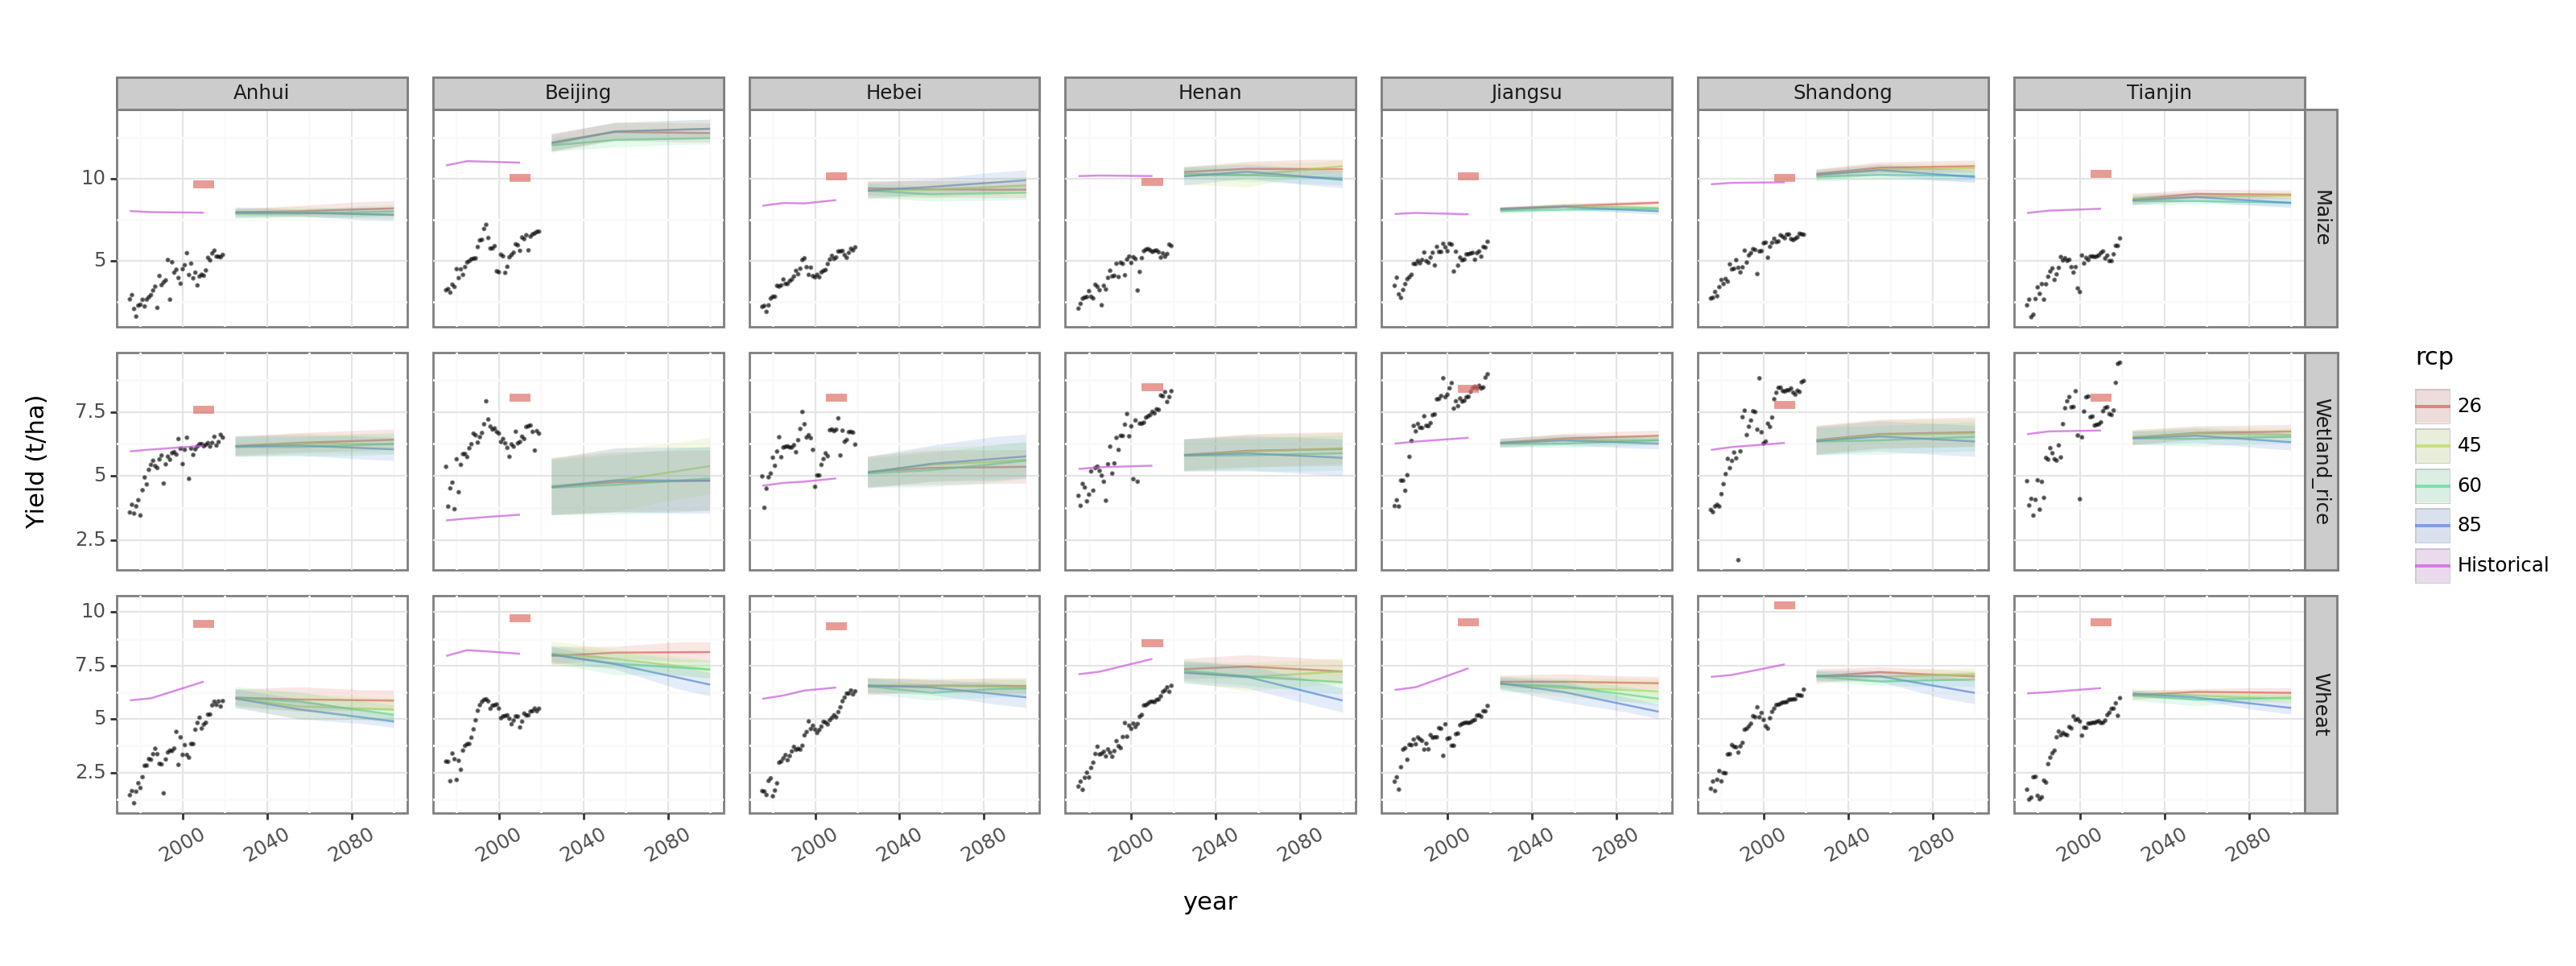

<Figure Size: (1600 x 600)>

In [23]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook yield
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),alpha=0.5,size=0.2) +
 # GAEZ_yield
 geom_line(anchor_attainable_converted_df, aes('year','Mean Production',color='rcp'),alpha=0.7) +
 geom_ribbon(anchor_attainable_converted_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.15) +
 # GYGA_yield
 geom_line(GYGA_with_area_ratio, aes('year','Mean Production'),size=2,color='#de6f67',alpha=0.7) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g